<a href="https://colab.research.google.com/github/entc-17-fyp-20/WPF_Data_Visualization/blob/Kusal/LSTM_RNN_model_for_short_term_power_forecasting_Merged_CEB_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dataframe** 

In [1]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image
%matplotlib inline
import plotly.express as px
import io


pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

url1 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/S6%2010%20seconed%20data.csv' #S6 10 seconed data.csv
url2 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/AE59_1.csv' #AE59_1
url3 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/AE59_2.csv' #AE59_2
url4 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V08%20June%2010%20sec%20data.csv' #V08 June 10 sec data.csv; does not contain current columns
url5 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V13%20June%2010%20sec%20data.csv' #V13 June 10 sec data.csv
url6 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V08%20July%2010%20sec%20data.csv' #V08 July 10 sec data.csv
url7 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/V13%20July%2010%20sec%20data.csv' #V13 July 10 sec data.csv
url8 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/Mannar.csv'  #Mannar dataset-10_min-wind_speed.csv
url9 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/Mannar%20full%20data.csv' #Mannar full data set.csv
url10 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/2018%20Scada%20Data%20of%20a%20Wind%20Turbine%20in%20Turkey.csv' #2018 Scada Data of a Wind Turbine in Turkey - 10 min resolution data
url11 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/CEB%20new%20updated(Only%20actual).csv' #CEB new dataset
url12 = 'https://raw.githubusercontent.com/entc-17-fyp-20/Datasets/main/CEB_dataset_full_august_to_december.csv' #merged CEB dataset


**Train an validation data set**

In [2]:
df = pd.read_csv(url12)
df=pd.DataFrame(df)
df_temp=df.copy()

In [3]:
df=df_temp[:5000] #8/1/2021 0:00 to 9/30/2021 23:50

In [4]:
# test_set_1 = df_temp[5000:5500]  #10/1/2021 00:00 to 10/10/2021 23:50
# test_set_2 = df_temp[10168:11608] #10/11/2021 00:00 to 10/20/2021 23:50
# test_set_3 = df_temp[11608:13048] #10/21/2021 00:00 to 10/30/2021 23:50

# dataset_index=1

# if dataset_index==1:
#   df_test = test_set_1
# elif dataset_index==2:
#   df_test = test_set_2
# elif dataset_index==3:
#   df_test = test_set_3

#df_test

**Rename column names**

In [5]:
col_1=(df.columns)[0]
col_2=(df.columns)[1]
feature = 'Active Power'
feature_1 = 'Forecasted Power'
df.rename(columns={col_1 :'Date & Time' , col_2 : feature},inplace=True)
#df


In [6]:
#df_temp.loc[13047]

**Set Data & Time as index**

In [7]:
df=df.set_index('Date & Time')
#df

**Divide train and validation sets**

In [8]:
L=len(df)
valid_start=int(8*L/10)

train,valid=df[:valid_start],df[valid_start:]

#print(train.shape)
#print(valid.shape)
#print(test.shape)

#print(train.describe())
#print(valid.describe())
#print(test.describe())

# **Data preparation**

In [9]:
T = 6
HORIZON = 1

In [10]:
scaler = MinMaxScaler()
train=pd.DataFrame(train[feature])
train[feature] = scaler.fit_transform(train)

train_shifted = train.copy()
train_shifted['y_t+1'] = train_shifted[feature].shift(-1)
#train_shifted.head(10)

**Creating input data to model (Getting T lagged vaules)**

In [11]:
for t in range(1, T+1):
    train_shifted['active_power_t-'+str(T-t)] = train_shifted[feature].shift(T-t)
train_shifted = train_shifted.rename(columns={feature:'Original_active_power'})

# 4.Discard any samples with missing values
train_shifted = train_shifted.dropna(how='any')
#train_shifted.head(10)

**Train input and target arrays**

In [12]:
y_train = np.array(train_shifted["y_t+1"])
X_train=np.array(train_shifted[['active_power_t-'+str(T-t) for t in range(1, T+1)]])

In [13]:
# This is an important step to reshape the X into 3 dimension array
X_train = X_train.reshape(X_train.shape[0], T, 1)

In [14]:
#print(y_train.shape)
#print(X_train.shape)

**Data preparation - Validation data**

In [15]:
valid=pd.DataFrame(valid[feature])
valid_new=df[valid_start-T+1:] #Add T values beforehand to the validation set
valid_new=pd.DataFrame(valid_new[feature])
#valid_new.head(20)

In [16]:
valid_new[feature]=scaler.transform(valid_new)

#Validataion set preparation(Lagged values,create input and target arrays,reshape)]

valid_shifted = valid_new.copy() 
valid_shifted['y_t+1'] = valid_shifted[feature].shift(-1)
valid_shifted.head(10)

for t in range(1, T+1):
    valid_shifted['active_power_t-'+str(T-t)] = valid_shifted[feature].shift(T-t)
vali_shifted = valid_shifted.rename(columns={feature:'Original_active_power'})

valid_shifted = valid_shifted.dropna(how='any')

y_valid = np.array(valid_shifted["y_t+1"])
X_valid=np.array(valid_shifted[['active_power_t-'+str(T-t) for t in range(1, T+1)]])
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)

In [17]:
#print(y_valid.shape)
#print(X_valid.shape)

# **Implement the GRU-RNN**

In [18]:
import tensorflow as tf
from keras.models import Model, Sequential
#from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

In [24]:
UNITS = 5 # number of units in the RNN layer
BATCH_SIZE = 16 # number of samples per mini-batch
EPOCHS = 25 # maximum number of times the training algorithm will cycle through all samples

In [20]:
win_length=6
batch_size=16
num_feature=1

In [21]:
model=tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(64,input_shape=(win_length,num_feature),return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.6))
model.add(tf.keras.layers.LSTM(32,return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.6))
model.add(tf.keras.layers.Dropout(0.1))
# model.add(tf.keras.layers.LSTM(64,return_sequences=True))
# model.add(tf.keras.layers.LeakyReLU(alpha=0.6))
# model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.LSTM(16,return_sequences=False))
model.add(tf.keras.layers.Dropout(0.1))
model.add(tf.keras.layers.Dense(1))

In [ ]:
model = Sequential()
model.add(GRU(UNITS, input_shape=(T, 1)))
model.add(Dense(HORIZON))

In [22]:
model.compile(optimizer='RMSprop', loss='mse')
#model.summary()

In [23]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [25]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop],
                    verbose=1)

Epoch 1/25
250/250 [==============================] - 8s 13ms/step - loss: 0.0293 - val_loss: 0.0120
Epoch 2/25
250/250 [==============================] - 2s 8ms/step - loss: 0.0144 - val_loss: 0.0227
Epoch 3/25
250/250 [==============================] - 2s 8ms/step - loss: 0.0123 - val_loss: 0.0132
Epoch 4/25
250/250 [==============================] - 2s 8ms/step - loss: 0.0112 - val_loss: 0.0092
Epoch 5/25
250/250 [==============================] - 2s 8ms/step - loss: 0.0107 - val_loss: 0.0116
Epoch 6/25
250/250 [==============================] - 2s 8ms/step - loss: 0.0093 - val_loss: 0.0070
Epoch 7/25
250/250 [==============================] - 2s 9ms/step - loss: 0.0080 - val_loss: 0.0066
Epoch 8/25
250/250 [==============================] - 4s 14ms/step - loss: 0.0069 - val_loss: 0.0038
Epoch 9/25
250/250 [==============================] - 5s 20ms/step - loss: 0.0059 - val_loss: 0.0040
Epoch 10/25
250/250 [==============================] - 2s 9ms/step - loss: 0.0051 - val_loss: 0.0

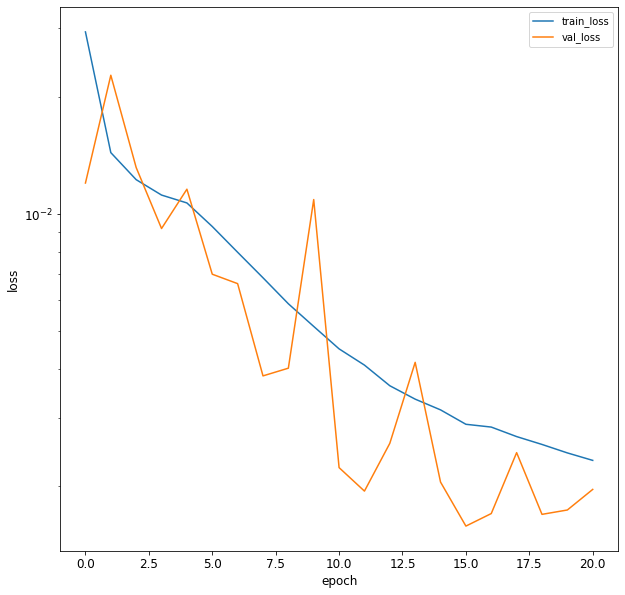

In [26]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Save the weights
path = '/content/drive/MyDrive/Colab Notebooks/Weights/GRU/model.h5'
model.save(path)

# **Evaluate the model**

**Load test data set**

In [27]:
#df_test = pd.read_csv(url11)
#df_test=pd.DataFrame(df_test)

In [28]:
#df_test=df_test.drop(0)
#df_test=df_test.head(200)

In [29]:
test_set_1 = df_temp[5000:5200]  #10/1/2021 00:00 to 10/10/2021 23:50
test_set_2 = df_temp[10168:11608] #10/11/2021 00:00 to 10/20/2021 23:50
test_set_3 = df_temp[11608:13048] #10/21/2021 00:00 to 10/30/2021 23:50

dataset_index=1

if dataset_index==1:
  df_test = test_set_1
elif dataset_index==2:
  df_test = test_set_2
elif dataset_index==3:
  df_test = test_set_3



In [30]:
col_1=(df_test.columns)[0]
col_2=(df_test.columns)[1]
col_3=(df_test.columns)[2]
feature = 'Active Power'
feature_1 = 'Forecasted Power'
df_test.rename(columns={col_1 :'Date & Time' , col_2 : feature ,col_3 :feature_1},inplace=True)

In [31]:
df_test=df_test.set_index('Date & Time')
#df_test = df_test.apply(pd.to_numeric)
#df_test=df_test.div(1000)

In [32]:
count = (df_test[feature] == 0).sum()
count

0

**Preprocessing technique**

In [33]:
#df_test[feature]=df_test[feature].replace(0,df_test[feature].median())
df_test[feature]=df_test[feature].replace(to_replace=0, method='ffill').values

In [34]:
scaler = MinMaxScaler()
test=pd.DataFrame(df_test[feature])
test[feature] = scaler.fit_transform(test)


In [35]:

test_shifted = test.copy()
test_shifted['y_t+1'] = test_shifted[feature].shift(-1)

for t in range(1, T+1):
    test_shifted['active_power_t-'+str(T-t)] = test_shifted[feature].shift(T-t)
test_shifted = test_shifted.rename(columns={feature:'Original_active_power'})

forecasted_values=np.array(df_test[feature_1])
test_shifted[feature_1] = forecasted_values
#test_shifted

In [36]:
test_shifted = test_shifted.dropna(how='any')
y_test = np.array(test_shifted['y_t+1'])
X_test=np.array(test_shifted[['active_power_t-'+str(T-t) for t in range(1, T+1)]])
X_test = X_test.reshape(X_test.shape[0], T, 1)
#X_test

In [37]:
print(y_test.shape)
print(X_test.shape)

(194,)
(194, 6, 1)


In [38]:
predictions = model.predict(X_test)
predictions=pd.DataFrame(predictions)
#predictions

In [39]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['Date & Time'] = test_shifted.index
eval_df = pd.melt(eval_df, id_vars='Date & Time', value_name='prediction', var_name='h')
eval_df['actual'] = np.transpose(y_test).ravel()
eval_df['prediction'] =predictions 

eval_df[feature_1]=np.array(test_shifted[feature_1])
#eval_df

In [40]:
eval_df[['prediction']]=scaler.inverse_transform(np.array(eval_df[['prediction']]))
eval_df[['actual']]=scaler.inverse_transform(np.array(eval_df[['actual']]))
eval_df

,Date & Time,h,prediction,actual,Forecasted Power
0,9/5/2021 3:30,t+1,103.73,101.05,101.51
1,9/5/2021 3:40,t+1,103.90,101.05,101.59
2,9/5/2021 3:50,t+1,103.83,101.07,101.65
3,9/5/2021 4:00,t+1,103.90,100.94,101.72
4,9/5/2021 4:10,t+1,103.65,101.04,101.64
...,...,...,...,...,...
189,9/6/2021 11:00,t+1,99.99,96.90,97.60
190,9/6/2021 11:10,t+1,98.98,95.60,98.29
191,9/6/2021 11:20,t+1,97.71,90.44,98.55
192,9/6/2021 11:30,t+1,89.20,91.59,99.06


**MAPE of our model**

In [41]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

actual = eval_df['actual']
pred = eval_df['prediction']

mape(actual, pred)

3.752890163433998

**RMSE of our model**

In [42]:
def rmse(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    x=np.mean((actual - pred)**2)
    return np.sqrt(x)

actual = eval_df['actual']
pred = eval_df['prediction']

rmse(actual, pred)

3.3113940427848814

**MAPE of CEB model**

In [43]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

actual = eval_df['actual']
pred = eval_df['Forecasted Power']

mape(actual, pred)

11.523585084980532

**RMSE of CEB model**

In [44]:
def rmse(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    x=np.mean((actual - pred)**2)
    return np.sqrt(x)

actual = eval_df['actual']
pred = eval_df['Forecasted Power']

rmse(actual, pred)

9.922586638393762

In [45]:
fig1 = px.line(eval_df,x='Date & Time', y=['actual',feature_1,'prediction'],labels={ "value": 'Active power (MW)'},title="GRU model:Expected vs predicted power forecasting") 
fig1.update_layout(xaxis_title_font_size=16,yaxis_title_font_size=16,title_font_color='red',title_font_size=20)
fig1.show()

In [46]:
fig2 = px.line(eval_df,x='Date & Time', y=['actual','prediction'],labels={ "value": 'Active power (MW)'},title="GRU model:Expected vs forecasted power") 
fig2.update_layout(xaxis_title_font_size=16,yaxis_title_font_size=16,title_font_color='red',title_font_size=20)
fig2.show()

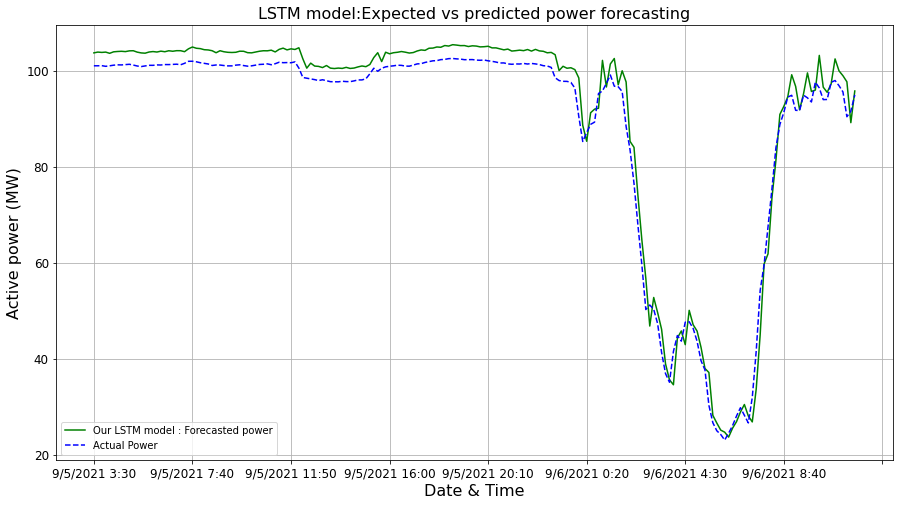

In [52]:
eval_df.plot(x='Date & Time', y=['prediction','actual'], style=['g','--b'],fontsize=12, figsize=(15, 8))
plt.title("LSTM model:Expected vs predicted power forecasting",fontsize=16)
plt.xlabel('Date & Time', fontsize=16)
plt.ylabel('Active power (MW)', fontsize=16)
plt.grid()
plt.legend(['Our LSTM model : Forecasted power', 'Actual Power'])
plt.savefig("LSTM-results.pdf")
plt.savefig("LSTM-results.png")
plt.show()

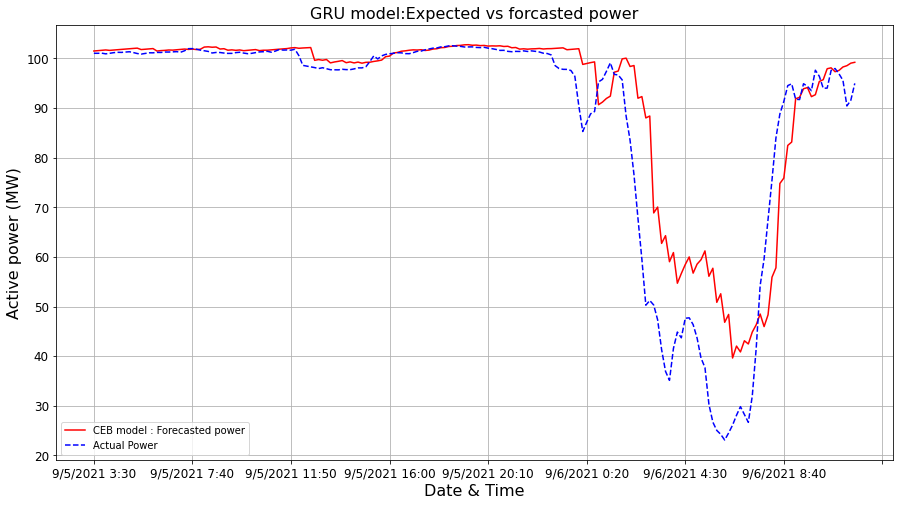

In [48]:
eval_df.plot(x='Date & Time', y=[feature_1, 'actual'], style=['r', '--b'],fontsize=12, figsize=(15, 8))
plt.title("GRU model:Expected vs forcasted power",fontsize=16)
plt.xlabel('Date & Time', fontsize=16)
plt.ylabel('Active power (MW)', fontsize=16)
plt.grid()
plt.legend(['CEB model : Forecasted power', 'Actual Power'])
plt.savefig("GRU-results-1.pdf")
plt.savefig("GRU-results-1.png")
plt.show()

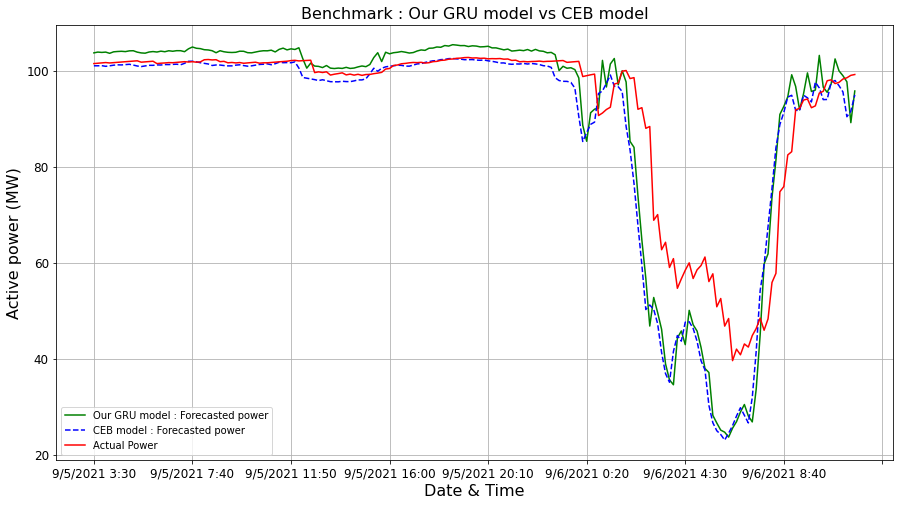

In [49]:
eval_df.plot(x='Date & Time', y=['prediction','actual',feature_1], style=['g','--b','r'],fontsize=12, figsize=(15, 8))
plt.title("Benchmark : Our GRU model vs CEB model",fontsize=16)
plt.xlabel('Date & Time', fontsize=16)
plt.ylabel('Active power (MW)', fontsize=16)
plt.grid()
plt.legend(['Our GRU model : Forecasted power','CEB model : Forecasted power', 'Actual Power'])
plt.savefig("benchmark.pdf")
plt.savefig("benchmark.png")
plt.show()